In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from matplotlib.patches import Ellipse
from matplotlib import patches
import seaborn as sns
%matplotlib notebook

In [ ]:
from objective_function import *
from optimiser import *

In [ ]:
import numpy as np
from abc import ABC, abstractmethod

class optimizer(ABC):
    @abstractmethod
    def set_parameters(self, para):
        '''
        input: parameters, in dictionary
        '''
        pass
    @abstractmethod
    def optimise(self, objective_cls):
        '''
        input: objective function class
        output: empirical found optimal, optimum, and statistics of procedure information
        '''
        pass
    
class adjust_optimizer(optimizer):
    def adjust(self, x0, obj):
        self.x0 = x0
        return self.optimise(obj)
    
class cma_es(optimizer):
    def set_parameters(self, paras):
        self.mean0 = paras['mean0'] 
        self.std = paras['std']
        self.tol = paras['tol']
        self.adjust_func = paras['adjust_func']
        self.max_iter = 400
        # set none to use default value 
        self.cluster_size = None if 'cluster_size' not in paras.keys() else paras['cluster_size']
        self.survival_size = None if 'survival_size' not in paras.keys() else paras['survival_size']
        self.record = True if 'multi_runs' not in paras.keys() else paras['multi_runs']
    def optimise(self, obj):
        '''
        @param obj: objective function class instance
        return arg: found minimum arguments
               val: found minimum value
               stats: collection of recorded statistics for post-analysis
        '''                  
        def update_mean(x):
            return (weights @ x).reshape(dim, 1)
        def update_ps(ps, sigma, C, mean, mean_old):
            return (1 - cs) * ps + np.sqrt(cs * (2 - cs) * mueff) * invsqrtC @ (mean - mean_old) / sigma 
        def update_pc(pc, sigma, ps, mean, mean_old):
            hsig = np.abs(ps) / np.sqrt(1 - (1 - cs)**(2 * iter_/lambda_)) / chiN < 1.4 + 2/(dim + 1)
            return (1 - cc) * pc + hsig * np.sqrt(cc * (2 - cc) * mueff) * (mean - mean_old) / sigma
        def update_C(C, pc, x, mean_old, sigma):
            hsig = np.abs(ps) / np.sqrt(1 - (1 - cs)**(2 * iter_/lambda_)) / chiN < 1.4 + 2/(dim + 1)
            artmp = (1 / sigma) * (x - mean_old.reshape(1, dim))
            return (1 - c1 - cmu) * C + c1 * (pc * pc.T + (1 - hsig) * cc * (2 - cc) * C) + cmu * artmp.T @ np.diag(weights) @ artmp
        def update_sigma(sigma, ps):
            return sigma * np.exp((cs / damps) * (np.linalg.norm(ps)/ chiN - 1))
        def not_moving(stats, tol):
            return np.linalg.norm(stats['arg'][-1] - stats['arg'][-2]) < tol \
                or np.linalg.norm(stats['val'][-1] - stats['val'][-2]) < tol \
                or np.linalg.norm(stats['mean'][-1] - stats['mean'][-2]) < tol    

        print("*******starting optimisation from intitial mean: ", self.mean0.ravel())
        # User defined input parameters 
        dim = 2    
        sigma = 0.3
        D = self.std / sigma
        mean = self.mean0

        # the size of solutions group
        lambda_ = 4 + int(3 * np.log(dim)) if self.cluster_size == None else self.cluster_size  
        # only best "mu" solutions are used to generate iterations
        mu = int(lambda_ / 2) if self.survival_size == None else self.survival_size
        # used to combine best "mu" solutions                                               
        weights = np.log(mu + 1/2) - np.log(np.arange(mu) + 1) 
        weights = weights / np.sum(weights)     
        mueff = np.sum(weights)**2 / np.sum(weights**2) 

        # Strategy parameter setting: Adaptation
        # time constant for cumulation for C
        cc = (4 + mueff / dim) / (dim + 4 + 2 * mueff / dim)  
        # t-const for cumulation for sigma control
        cs = (mueff + 2) / (dim + mueff + 5)  
        # learning rate for rank-one update of C
        c1 = 2 / ((dim + 1.3)**2 + mueff)    
        # and for rank-mu update
        cmu = min(1 - c1, 2 * (mueff - 2 + 1 / mueff) / ((dim + 2)**2 + mueff))  
        # damping for sigma, usually close to 1  
        damps = 1 + 2 * max(0, np.sqrt((mueff - 1)/( dim + 1)) - 1) + cs                                                                 

        # Initialize dynamic (internal) strategy parameters and constants
        # evolution paths for C and sigma
        pc = np.zeros((dim, 1))     
        ps = np.zeros((dim, 1)) 
        # B defines the coordinate system
        B = np.eye(dim)       
        # covariance matrix C
        C = B * np.diag(D**2) * B.T 
        # C^-1/2 
        invsqrtC = B * np.diag(D**-1) * B.T   
        # expectation of ||N(0,I)|| == norm(randn(N,1)) 
        chiN = dim**0.5 * (1 - 1/(4 * dim) + 1 / (21 * dim**2))  

        # --------------------  Initialization --------------------------------  
        x, x_old, f = np.zeros((lambda_, dim)), np.zeros((lambda_, dim)), np.zeros((lambda_,))
        stats = {}
        stats['val'], stats['arg'] = [], []
        stats['x_adjust'] = []
        iter_eval, stats['evals_per_iter'] = np.zeros((lambda_, )), []
        stats['mean'], stats['std'] = [], []
        stats['status'] = None
        iter_, eval_ = 0, 0

        # initial data in record
        for i in range(lambda_):
            x[i] = (mean + np.random.randn(dim, 1)).ravel()
            f[i] = obj.func(x[i])
        idx = np.argsort(f)
        x_ascending = x[idx]
        stats['arg'].append(x_ascending)
        stats['val'].append(f[idx])
        stats['mean'].append(mean)
        stats['std'].append(sigma * B @ np.diag(D))
        stats['evals_per_iter'].append(np.ones((lambda_,)))
        stats['x_adjust'].append(np.vstack((x.T.copy(), x.T.copy())))

        # optimise by iterations
        try:
            while iter_ < self.max_iter:
                iter_ += 1
                
                # generate candidate solutions with some stochastic elements
                for i in range(lambda_):
                    x[i] = (mean + sigma * B @ np.diag(D) @ np.random.randn(dim, 1)).ravel() 
                    x_old[i] = x[i]
                    x[i], eval_cnt = self.adjust_func.adjust(x[i], obj)
                    f[i] = obj.func(x[i])
                    eval_ += eval_cnt
                    iter_eval[i] = eval_cnt
                # sort the value and positions of solutions 
                idx = np.argsort(f)
                x_ascending = x[idx]

                # update the parameter for next iteration
                mean_old = mean
                mean = update_mean(x_ascending[:mu])
                ps =   update_ps(ps, sigma, C, mean, mean_old)
                pc =   update_pc(pc, sigma, ps, mean, mean_old)
                sigma = update_sigma(sigma, ps)
                C =    update_C(C, pc, x_ascending[:mu], mean_old, sigma)
                C = np.triu(C) + np.triu(C, 1).T
                D, B = np.linalg.eig(C)
                D = np.sqrt(D)
                invsqrtC = B @ np.diag(D**-1) @ B

                # record data during process for post analysis
                if self.record == True:
                    stats['arg'].append(x_ascending)
                    stats['val'].append(f[idx])
                    stats['mean'].append(mean)
                    stats['std'].append(sigma * B @ np.diag(D))
                    stats['evals_per_iter'].append(iter_eval.copy())
                    stats['x_adjust'].append(np.vstack((x_old.T.copy(), x.T.copy())))
                    
                # check the stop condition
                if np.max(D) > (np.min(D) * 1e6):
                    stats['status'] = 'diverge'
                    print('diverge, concentrate in low dimension manifold')
                    break
                if not_moving(stats, self.tol) :
                    break   
        except np.linalg.LinAlgError as err:
            stats['status'] = 'diverge'
            print('diverge, raise LinAlgError!')
        finally:
            print('eigenvalue of variance = {}'.format(D))
            print('total iterations = {}, total evaluatios = {}'.format(iter_, eval_))
            print('found minimum position = {}, found minimum = {}'.format(stats['arg'][-1][0], stats['val'][-1][0]))

        # carry statistics info before quit
        stats['arg'] = np.array(stats['arg'])
        stats['val'] = np.array(stats['val'])
        stats['mean'] = np.array(stats['mean'])
        stats['std'] = np.array(stats['std'])
        stats['evals_per_iter'] = np.array(stats['evals_per_iter'])
        stats['x_adjust'] = np.array(stats['x_adjust'])
        return stats['arg'][-1][0], stats['val'][-1][0], stats
    
    
class do_nothing(adjust_optimizer):
    def set_parameters(self, paras):
        return None
    def optimise(self, obj):
        return self.x0, 1
    
class round_off(adjust_optimizer):
    def set_parameters(self, paras):
        pass
    def optimise(self, obj):
        return np.round(self.x0), 1
    
class line_search(adjust_optimizer):
    def __init__(self, alpha, beta, max_iter=100, tol=1e-5):
        self.alpha = alpha
        self.beta = beta
        self.max_iter = max_iter
        self.tol = tol
    def set_parameters(self, paras):
        self.alpha = paras['alpha']
        self.beta = paras['beta']
        self.max_iter = paras['max_iter']
        self.tol = paras['tol']
    def optimise(self, obj):
        '''
        @param x0: initial point position
        @param alpha: initial step size
        @param beta: control the armijo condition
        @return x: point position after moving to local minimum
        '''
        x = self.x0.copy()
        print(x)
        alpha_ = self.alpha
        tao = 0.5
        fx = obj.func(x)
        p = - obj.dfunc(x)
        fnx = obj.func(x + alpha_ * p)
        eval_cnt = 4
        for k in range(self.max_iter):
            while fnx > fx + alpha_ * self.beta * (-p @ p):
                alpha_ *= tao
                print(alpha_)
                fnx = obj.func(x + alpha_ * p)
                eval_cnt += 1
            x += alpha_ * p
            fx = fnx
            p = -obj.dfunc(x)
            fnx = obj.func(x + alpha_ * p)
            eval_cnt += 2
            if np.linalg.norm(p) < self.tol:
                break
        print(x)
        raise ValueError(str(obj.dfunc(self.x0)), str(eval_cnt), str(x), str(self.x0))
        return x, eval_cnt

class line_search_1step(adjust_optimizer):
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        self.max_iter = 4
        self.tol = 1e-2
    def set_parameters(self, paras):
        self.alpha = paras['alpha']
        self.beta = paras['beta']
        self.max_iter = paras['max_iter']
        self.tol = paras['tol']
    def optimise(self, obj):
        '''
        @param x0: initial point position
        @param alpha: initial step size
        @param beta: control the armijo condition
        @return x: point position after moving to local minimum
        '''
        x = self.x0.copy()
        alpha_ = self.alpha
        tao = 0.5
        fx = obj.func(x)
        p = - obj.dfunc(x)
        eval_cnt = 4
        while obj.func(x + alpha_ * p) > fx + alpha_ * self.beta * (-p @ p):
            alpha_ *= tao
            eval_cnt += 1
        x += alpha_ * p
        return x, eval_cnt

In [ ]:
class single_experiment:
    def set_objective(self, objective_func):
        self.objective_func = objective_func

    def set_optimise(self, optimizer):
        self.optimizer = optimizer

    def do(self):
        optimal, optimum, statistics = self.optimizer.optimise(self.objective_func)
        if np.linalg.norm(optimal - self.objective_func.get_optimal()) < 1e-1 \
        or np.linalg.norm(optimum - self.objective_func.get_optimum()) < 1e-1:
            statistics['status'] = 'global minimum'
        elif statistics['status'] != 'diverge':
            statistics['status'] = 'local minimum'
        print(statistics['status'])
        self.analyser = post_analysis(statistics, self.objective_func)

In [ ]:
optimal, optimum, statistics = cma.optimise(ak)
if np.linalg.norm(optimal - ak.get_optimal()) < 1e-1 \
or np.linalg.norm(optimum - ak.get_optimum()) < 1e-1:
    statistics['status'] = 'global minimum'
elif statistics['status'] != 'diverge':
    statistics['status'] = 'local minimum'
print(statistics['status'])

In [244]:
np.random.seed(34)
# setup objective function
ak = ackley()
# setup adjust function optimizer
default = do_nothing()
# setup optmizer
paras = {}
paras['mean0'] = np.array([[44], [110]])
paras['std'] = np.ones((2,)) * 0.3
paras['tol'] = 1e-5
paras['adjust_func'] = default

cma = cma_es()
cma.set_parameters(paras)

# boil down to one expreiment
exp1 = single_experiment()
exp1.set_objective(ak)
exp1.set_optimise(cma)
exp1.do()


*******starting optimisation from intitial mean:  [ 44 110]
eigenvalue of variance = [0.06495864 0.09848856]
total iterations = 32, total evaluatios = 192
found minimum position = [ 43.99999017 110.00024329], found minimum = 20.000000532388107
local minimum


In [245]:
np.random.seed(34)
line = line_search(alpha=2, beta=0.1)
paras['adjust_func'] = line
cma.set_parameters(paras)
exp1.set_optimise(cma)
exp1.do()

*******starting optimisation from intitial mean:  [ 44 110]
eigenvalue of variance = [0.94519907 1.00240962]
total iterations = 2, total evaluatios = 910
found minimum position = [ 43.99999992 105.00000011], found minimum = 19.99999796411213
local minimum


In [243]:
exp1.analyser.print_points_before_and_after_adjust()

iter= 0 
before
 [[ 44.2438351   42.43882301  43.64793766  44.28929924  44.47792422
   44.75244345]
 [109.25268182 109.53574688 108.71850812 110.9800285  110.45081813
  109.48942821]] 
after
 [[ 44.2438351   42.43882301  43.64793766  44.28929924  44.47792422
   44.75244345]
 [109.25268182 109.53574688 108.71850812 110.9800285  110.45081813
  109.48942821]] 

iter= 1 
before
 [[ 41.88274359  43.30351362  37.7157519   39.69757801  44.17854347
   43.99614109]
 [108.72704824 115.44542143 113.10786834 109.16531391 106.07506359
  113.78314079]] 
after
 [[ 42.00000018  42.00000001  38.00000006  40.00000009  43.99999991
   44.00000001]
 [108.99999996 115.00000018 113.00000011 108.99999991 106.00000013
  114.00000017]] 

iter= 2 
before
 [[ 42.92982148  44.97544107  40.24003002  45.93792262  42.25295784
   45.8517988 ]
 [102.7922768  107.82284188 110.46452215 104.93658239 102.87328069
  106.22455811]] 
after
 [[ 43.00000012  44.99999983  38.00000012  46.0000001   42.00000004
   45.99999988]
 [1

<IPython.core.display.Javascript object>


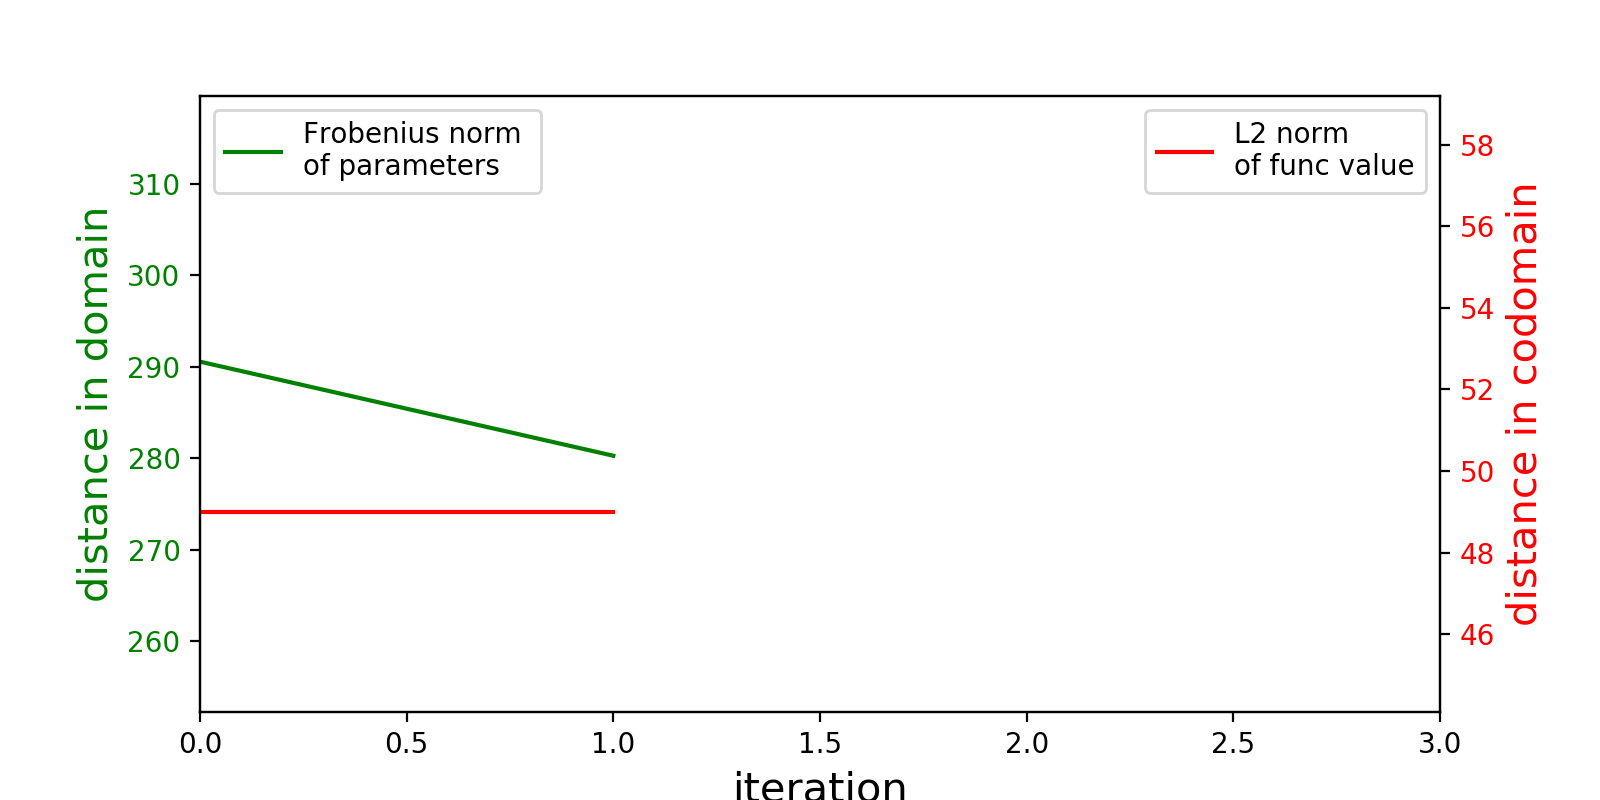

In [242]:
exp1.analyser.plot_distance()

In [ ]:
exp1.analyser.print_points_before_and_after_adjust()

In [ ]:
ro = round_off()
paras['adjust_func'] = ro
cma.set_parameters(paras)
exp1.set_optimise(cma)
exp1.do()

In [ ]:
l1 = line_search_1step(alpha=1, beta=2)
paras['adjust_func'] = l1
cma.set_parameters(paras)
exp1.set_optimise(cma)
exp1.do()

In [ ]:
exp1.analyser.print_points_before_and_after_adjust()

In [ ]:
exp1.analyser.print_evaluations_per_iteration()

In [ ]:
exp1.analyser.print_mean_variance()

In [ ]:
exp1.analyser.plot_distance()

In [ ]:
ana = post_analysis(statistics, ak)

In [ ]:
ana.plot_distance()

In [ ]:
ana.animate_moving_cluster()

In [ ]:
ana.animate_scatterplot_distance()

In [ ]:
ana.plot_moving_cluster()

In [ ]:
class post_analysis():
    def __init__(self, stats, obj):
        self.stats = stats
        self.obj = obj
    def print_mean_variance(self):
        # print mean and variance of each iteration
        for i, a in enumerate(self.stats['std']):
            print('iter=',i, 'mean=', self.stats['mean'][i].T , '\nvar=\n', a@a.T, '\n')

    def print_evaluations_per_iteration(self):
        for i, iter_ in enumerate(self.stats['evals_per_iter']):
            print('iter=', i, '\n', iter_.squeeze(),'\n') 

    def print_points_before_and_after_adjust(self):
        for i, iter_ in enumerate(self. stats['x_adjust']):
            print('iter=', i, '\nbefore\n', iter_[:2], '\nafter\n', iter_[2:], '\n') 

    def __cal_distance(self):
        self.distance_arg = np.linalg.norm(self.stats['arg'] - self.obj.get_optimal().reshape(1,1,2), axis=(1,2))
        self.distance_val = np.linalg.norm(self.stats['val'] - self.obj.get_optimum(), axis=1)
            
    def plot_distance(self):
        self.__cal_distance()
        fig = plt.figure(figsize=(8, 4))
        ax1 = fig.add_subplot(1, 1, 1)
        self.__plot_distance_common(ax1, self.stats['val'].shape[0]-1)
        
    def plot_moving_cluster(self):
        fig = plt.figure(figsize=(9, 9))
        row = col = 3
        unit = int(self.stats['val'].shape[0]/(row * col)/2)
        for i in range(row):
            for j in range(col):
                ax=fig.add_subplot(row, col, 1 + row * i + j)
                # draw x-axis and y-axis
                ax.axvline(c='grey', lw=1)
                ax.axhline(c='grey', lw=1)
                # draw the position of optimal 
                ax.scatter(self.obj.get_optimal()[0], self.obj.get_optimal()[1], c='red', s=15)
                ax.scatter(x=self.stats['arg'][unit * (row * i + j),:,0], y=self.stats['arg'][unit * (row * i + j),:,1], 
                           c=self.stats['val'][unit * (row * i + j)], vmin = 0, vmax = 10)
                ax.set_title("%d / %d"%(unit * (row * i + j), self.stats['arg'].shape[0]))
                plt.xlim([-4, 4])
                plt.ylim([-4, 4])
            
    def __plot_distance_common(self, ax1, i):
        ax1.plot(np.arange(i), self.distance_arg[1:i+1], color='green', label='Frobenius norm \nof parameters')
        ax1.set_xlim(0, self.stats['val'].shape[0])
        ax1.set_ylim(np.min(self.distance_arg)*0.9, np.max(self.distance_arg)*1.1)
        ax1.set_xlabel('iteration', fontsize=15)
        ax1.set_ylabel('distance in domain', color='green', fontsize=15)
        ax1.tick_params(axis='y', labelcolor='green')
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()  
        ax2.plot(np.arange(i), self.distance_val[1:i+1], color='red', label='L2 norm \nof func value')
        ax2.set_ylim(np.min(self.distance_val)*0.9, np.max(self.distance_val)*1.1)
        ax2.set_ylabel('distance in codomain', color='red', fontsize=15)
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.legend(loc='upper right') 
        
    def __draw_ellipse(self, ax, mean, std):
        eigVal_sqrt = np.linalg.norm(std, ord=2, axis=(0))
        eigVec = std / eigVal_sqrt
        width, height = 2 * 3 * eigVal_sqrt
        angle = np.arctan2(eigVec[0,1], eigVec[0,0]) * 180 / np.pi
        e1 = patches.Ellipse(mean, width, height,
                             angle=-angle, linewidth=2, fill=False, zorder=2)
        ax.add_patch(e1)
        ax.scatter(mean[0], mean[1], c='black', s=15)

    def __setup_scatter(self, ax, i):
        '''
        set up the plot of CMA-ES candidates at i-th iteration
        '''
        # draw x-axis and y-axis
        ax.axvline(c='grey', lw=1)
        ax.axhline(c='grey', lw=1)
        # draw the position of optimal 
        ax.scatter(self.obj.get_optimal()[0], self.obj.get_optimal()[1], c='red', s=15)
        # draw the trail of local minimum
        if 'trail' in self.stats.keys():
            ax.scatter(self.stats['trail'][0], self.stats['trail'][1], c='red', s=11)
        # draw candidates on scatter plot
        ax.set_xlim(np.min(self.stats['arg'][:,:,0]), np.max(self.stats['arg'][:,:,0]))
        ax.set_ylim(np.min(self.stats['arg'][:,:,1]), np.max(self.stats['arg'][:,:,1]))
        p = sns.scatterplot(x=self.stats['arg'][i,:,0], y=self.stats['arg'][i,:,1], color="r", hue=i, hue_norm=(0, self.stats['val'].shape[0]), legend=False)
        # draw ellipse representing 3 sigma areas of normal distribution
        self.__draw_ellipse(ax, self.stats['mean'][i], self.stats['std'][i])

    def animate_moving_cluster(self):
        def animate(i):
            plt.clf()
            ax = fig.add_subplot(1, 1, 1)    
            ax.set_title('iter=%d' % (i+1))
            self.__setup_scatter(ax, i+1)
        fig = plt.figure(figsize=(8,4))
        ani = animation.FuncAnimation(fig, animate, frames=self.stats['arg'].shape[0]-1, repeat=False, interval=500)
        return ani

    def animate_scatterplot_distance(self):
        def animate(i):
            plt.clf()
            # draw scatter and ellipse
            ax0 = fig.add_subplot(2, 1, 1)
            ax0.set_title('iter=%d, func_dist=%.3f,  arg_dist=%.3f, mean=(%.3f, %.3f)' % (i+1, self.distance_val[i+1], self.distance_arg[i+1], \
                                        self.stats['mean'][i+1,0], self.stats['mean'][i+1,1]))
            self.__setup_scatter(ax0, i+1)
            
            # plot distance
            ax1 = fig.add_subplot(2, 1, 2)
            self.__plot_distance_common(ax1, i+1)
        self.__cal_distance()
        fig = plt.figure(figsize=(8,4))
        ani = animation.FuncAnimation(fig, animate, frames=self.stats['val'].shape[0]-1, repeat=False, interval=500)
        return ani

In [ ]:
    
    def generate_point_cloud(self, sigma, alpha, beta, adjust, points):
        self.num = points.shape[0]
        self.res = np.zeros((self.num, ))
        self.points = points

        for i in range(self.num):
            val, arg, stats = cma_es_general(self.points[i].reshape(2,1), sigma, alpha, beta, adjust, 1e-3, self.func, self.dfunc, self.optimal, self.optimum)
            if(stats['status'] == 'd'):
                self.res[i] = 1
            elif(stats['status'] == 'l'):
                self.res[i] = 0.5
            else:
                self.res[i] = 0

    def plot_prob_vs_radius(self, *args):
        def count_global_min(res, points):        
            distance = np.linalg.norm(points, axis=1)
            idx = np.argsort(distance)
            dis_ascending = distance[idx]
            res_ascending = res[idx]
            prob = np.zeros((self.num, ))
            for i in range(self.num):
                prob[i] = np.sum(res_ascending[:i+1] == 0) / (i + 1) 
            return dis_ascending, prob
        argc = len(args)
        assert argc%2 == 0
        pair_cnt = int(argc / 2)
        dis_ascendings = np.zeros((self.num, pair_cnt + 1))
        probs = np.zeros((self.num, pair_cnt + 1))
        dis_ascendings[:,0], probs[:,0] = count_global_min(self.res, self.points)
        for i in range(pair_cnt):
            dis_ascendings[:,i+1], probs[:,i+1] = count_global_min(args[i*2], args[i*2+1])
        fig = plt.figure(figsize=(8,4))
        ax = fig.add_subplot(1, 1, 1)
        ax.set_xlim(0, np.max(dis_ascendings))
        ax.set_ylim(0, 2)
        ax.set_xlabel('distance from origin', fontsize=13)
        ax.set_ylabel('prob of global minminum', fontsize=13)
        for i in range(pair_cnt+1):
            ax.plot(dis_ascendings[:,i], probs[:,i])
        plt.show()

    def plot_cloud_point(self, other_points=None, other_res=None):
        fig = plt.figure(figsize=(7,7))
        '''
        # one quadrant
        x1 = np.hstack((self.points[:,0], self.points[:,1]))
        y1 = np.hstack((self.points[:,1], self.points[:,0]))
        res1 = np.hstack((self.res, self.res))
        # two qudrant
        x2 = np.hstack((x1, -x1))
        y2 = np.hstack((y1, y1))
        res2 = np.hstack((res1, res1))
        # four qudrant
        x = np.hstack((x2, -x2))
        y = np.hstack((y2, -y2))
        hue = np.hstack((res2, res2))
        '''
        x = self.points[:,0]
        y = self.points[:,1]
        hue = self.res
        p = sns.scatterplot(x=x, y=y, color="r", hue=hue, hue_norm=(0, 1), legend=False)
        if other_points != None and other_res != None:
            x = other_points[:,0]
            y = other_points[:,1]
            hue = other_res
            sns.scatterplot(x=x, y=y, color="r", hue=hue, hue_norm=(0, 1), legend=False)